In [12]:
# Feb 10, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Para calcular las estacionalidad, tendencia y residuo 
import statsmodels.api as sm

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [14]:
url = 'https://raw.githubusercontent.com/FerminDelgadoR/FisicaComputacional1/master/Actividad%203/Datos%20climatologicos.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()
df_meteo.info()
print(df_meteo.head())
print(df_meteo.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20300 entries, 0 to 20299
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   20300 non-null  datetime64[ns]
 1   Precip  20292 non-null  float64       
 2   Evap    9638 non-null   float64       
 3   Tmax    20196 non-null  float64       
 4   Tmin    20196 non-null  float64       
 5   Año     20300 non-null  int64         
 6   Mes     20300 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.1+ MB
       Fecha  Precip  Evap  Tmax  Tmin   Año  Mes
0 1961-01-01     0.0   NaN  24.0   6.5  1961  Jan
1 1961-01-02     0.0   NaN  24.5   8.5  1961  Jan
2 1961-01-03     0.0   NaN  25.0   9.0  1961  Jan
3 1961-01-04     0.0   NaN  23.0   9.5  1961  Jan
4 1961-01-05     0.5   NaN  22.0  10.0  1961  Jan
           Fecha  Precip  Evap  Tmax  Tmin   Año  Mes
20295 2016-09-26     0.0   4.0  39.0  22.0  2016  Sep
20296 2

In [15]:
# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
print(df_meteo_ts.head())
#print(df_meteo_ts.tail())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20300 entries, 1961-01-01 to 2016-09-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  20292 non-null  float64
 1   Evap    9638 non-null   float64
 2   Tmax    20196 non-null  float64
 3   Tmin    20196 non-null  float64
 4   Año     20300 non-null  int64  
 5   Mes     20300 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
1961-01-01     0.0   NaN  24.0   6.5  1961  Jan
1961-01-02     0.0   NaN  24.5   8.5  1961  Jan
1961-01-03     0.0   NaN  25.0   9.0  1961  Jan
1961-01-04     0.0   NaN  23.0   9.5  1961  Jan
1961-01-05     0.5   NaN  22.0  10.0  1961  Jan


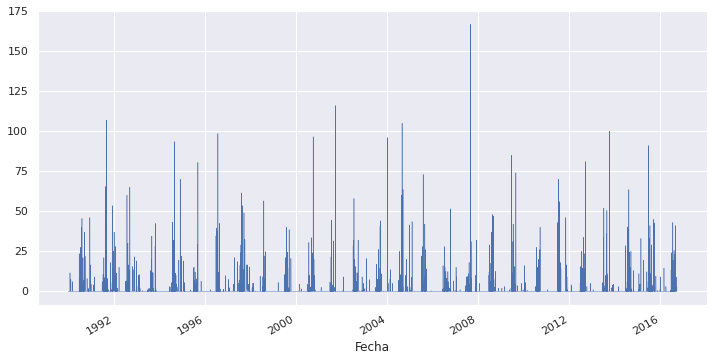

In [16]:
# Seleccionaremos un conjunto de años de 30 años  
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]


sns.set(rc={'figure.figsize':(12, 6)})

df_90['Precip'].plot(linewidth=0.5);



 


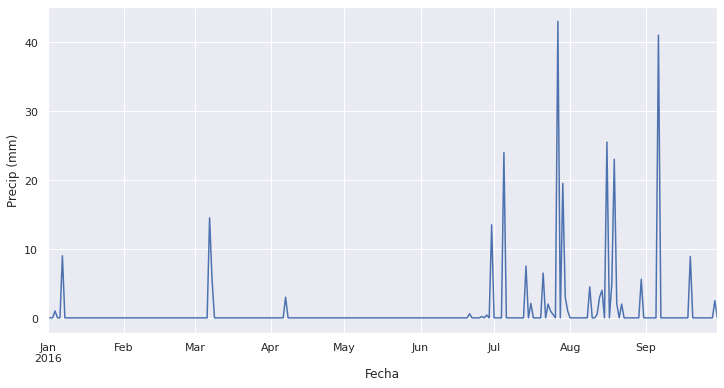

In [17]:
 ax = df_90.loc['2016', 'Precip'].plot()

ax.set_ylabel('Precip (mm)');

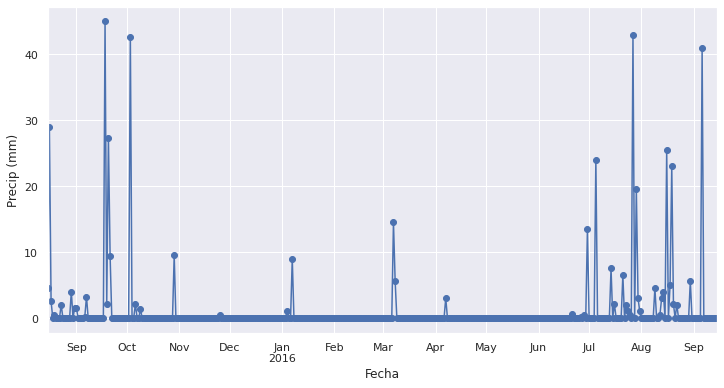

In [18]:
ax = df_90.loc['2015-08-15':'2016-09-15', 'Precip'].plot(marker='o', linestyle='-')

ax.set_ylabel('Precip (mm)');

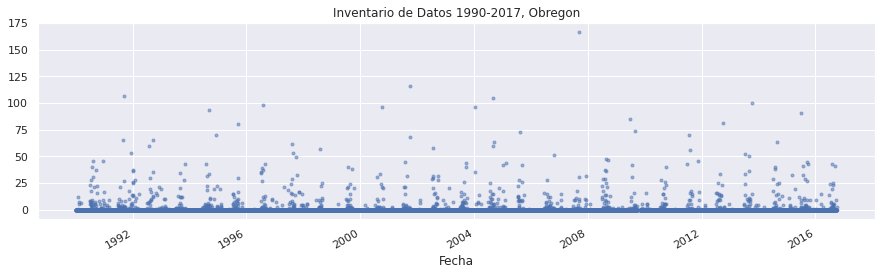

In [19]:

axes = df_90['Precip'].plot(marker='.', alpha=0.5, linestyle='None', 
                                  figsize=(15, 4), subplots=True)
plt.title('Inventario de Datos 1990-2017, Obregon');





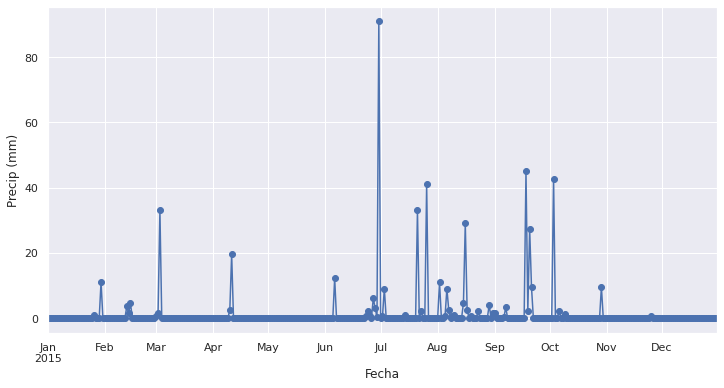

In [20]:
ax = df_90.loc['2015', 'Precip'].plot(marker='o', linestyle='-')

ax.set_ylabel('Precip (mm)');

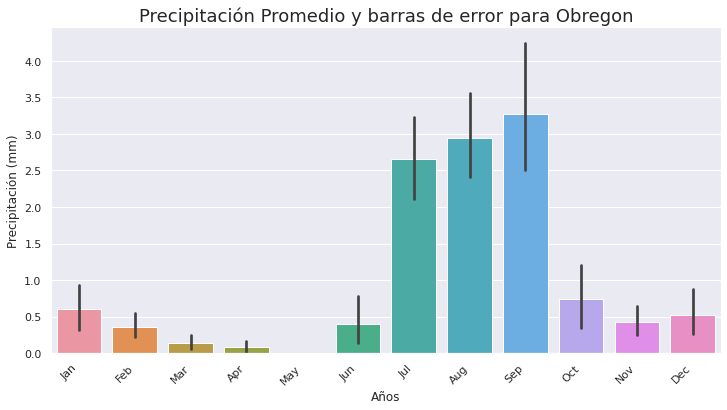

In [21]:
# Graficamos 30 años de datos usando la columna 'Año' en el eje x
g =sns.barplot(x='Mes', y='Precip', data=df_90);

# Rotamos 45º los Años en el eje x para mejor lectura
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right');

plt.xlabel('Años')
plt.ylabel('Precipitación (mm)')
plt.title('Precipitación Promedio y barras de error para Obregon', fontsize=18)

plt.show()

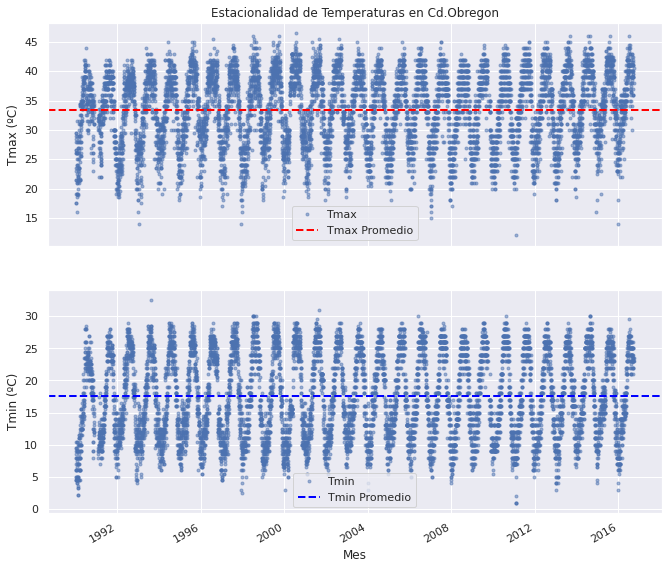

In [22]:
# Analizando Estacionalidad de los datos dos gráficas en una
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Rango de Tiempo
start, end = '1990', '2012'




# Primer subplot

f1 = df_90['Tmax'].plot(marker='.', alpha=0.5, linestyle='None' ,ax=axes[0])


l1 = axes[0].axhline(df_90.loc[start:end, 'Tmax'].mean(), color='red', linestyle='--', linewidth=2, label='Tmax Promedio');

#l12 = axes[0].axhline(df_90.loc[start:end, 'Tmin'].mean(), color='blue', linestyle='--', linewidth=2, label='Tmin Promedio');

axes[0].legend(loc='best');
axes[0].set_ylabel('Tmax (ºC)');
axes[0].set_xlabel('');
axes[0].set_title('Estacionalidad de Temperaturas en Cd.Obregon');





# Subplot 2
f2 = df_90['Tmin'].plot(marker='.', alpha=0.5, linestyle='None',ax=axes[1])

l2 = axes[1].axhline(df_90.loc[start:end, 'Tmin'].mean(), color='blue', linestyle='--', linewidth=2, label='Tmin Promedio');

#l21 = axes[1].axhline(df_90.loc[start:end, 'Tmax'].mean(), color='red', linestyle='--', linewidth=2, label='Tmax Promedio');
# Etiquetas
axes[1].legend(loc='best');
axes[1].set_ylabel('Tmin (ºC)');
axes[1].set_xlabel('Mes');
axes[1].set_title('');

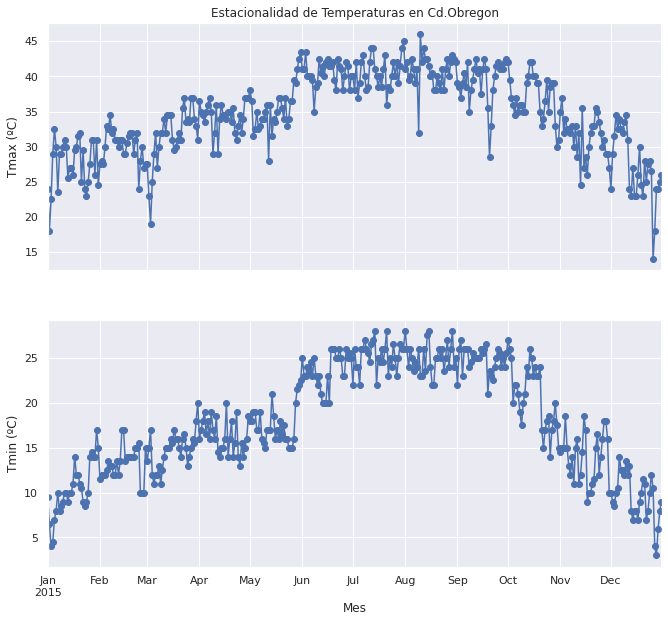

In [23]:
# Analizando Estacionalidad de los datos dos gráficas en una
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Rango de Tiempo





# Primer subplot
f1 = df_90.loc['2015', 'Tmax'].plot(marker='o', linestyle='-',ax=axes[0])




axes[0].set_ylabel('Tmax (ºC)');
axes[0].set_xlabel('');
axes[0].set_title('Estacionalidad de Temperaturas en Cd.Obregon');





# Subplot 2
f2 = df_90.loc['2015', 'Tmin'].plot(marker='o', linestyle='-',ax=axes[1])

axes[1].set_ylabel('Tmin (ºC)');
axes[1].set_xlabel('Mes');
axes[1].set_title('');

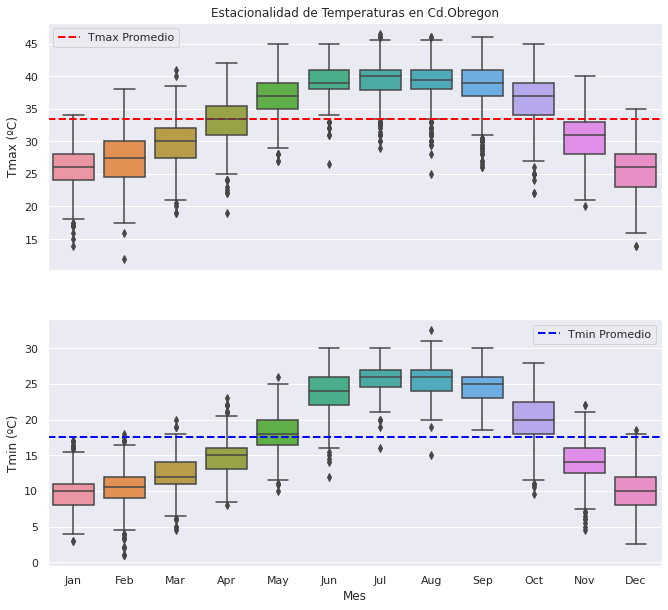

In [24]:
# Analizando Estacionalidad de los datos dos gráficas en una
fig, axes = plt.subplots(2, 1, figsize=(11, 10), sharex=True)
# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Rango de Tiempo
start, end = '1990', '2012'




# Primer subplot
f1 = sns.boxplot(data=df_90, x='Mes', y='Tmax', ax=axes[0])
l1 = axes[0].axhline(df_90.loc[start:end, 'Tmax'].mean(), color='red', linestyle='--', linewidth=2, label='Tmax Promedio');

#l12 = axes[0].axhline(df_90.loc[start:end, 'Tmin'].mean(), color='blue', linestyle='--', linewidth=2, label='Tmin Promedio');

axes[0].legend(loc='best');
axes[0].set_ylabel('Tmax (ºC)');
axes[0].set_xlabel('');
axes[0].set_title('Estacionalidad de Temperaturas en Cd.Obregon');





# Subplot 2
f2 = sns.boxplot(data=df_90, x='Mes', y='Tmin', ax=axes[1])

l2 = axes[1].axhline(df_90.loc[start:end, 'Tmin'].mean(), color='blue', linestyle='--', linewidth=2, label='Tmin Promedio');

#l21 = axes[1].axhline(df_90.loc[start:end, 'Tmax'].mean(), color='red', linestyle='--', linewidth=2, label='Tmax Promedio');
# Etiquetas
axes[1].legend(loc='best');
axes[1].set_ylabel('Tmin (ºC)');
axes[1].set_xlabel('Mes');
axes[1].set_title('');

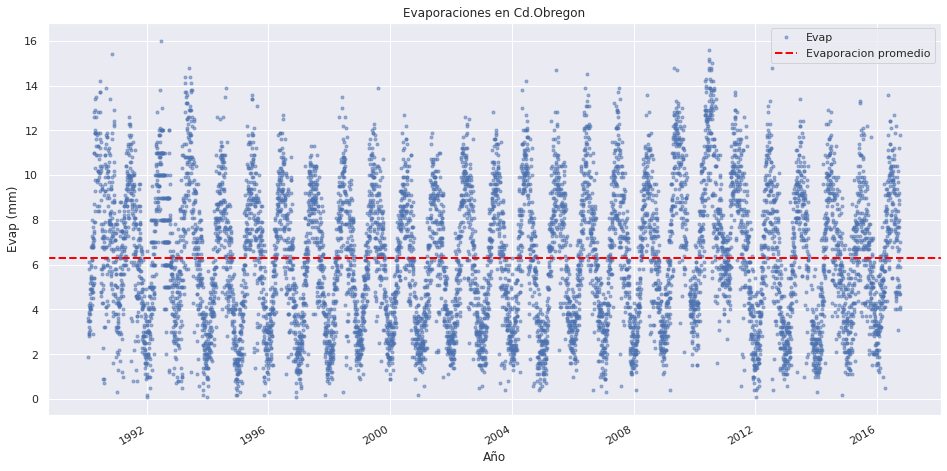

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(16, 8), sharex=True)
sns.set(rc={'figure.figsize':(12, 6)})
start, end = '1990', '2017'


f1 = df_90['Evap'].plot(marker='.', alpha=0.5, linestyle='None')
l1 = plt.axhline(df_90.loc[start:end, 'Evap'].mean(), color='red', linestyle='--', linewidth=2, label='Evaporacion promedio');


plt.legend(loc='best')
plt.ylabel('Evap (mm)')
plt.xlabel('Año');
plt.title('Evaporaciones en Cd.Obregon');

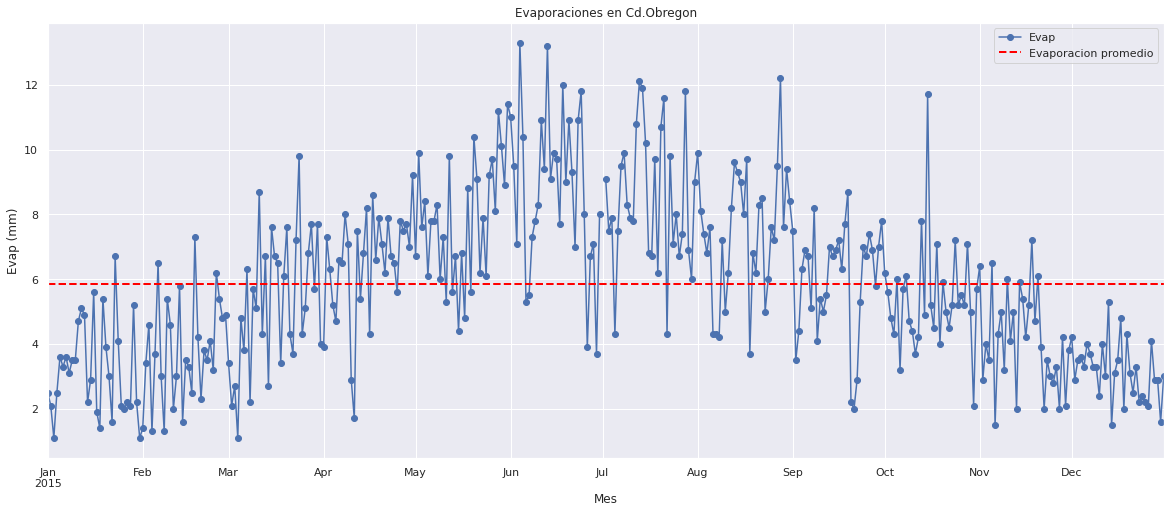

In [26]:

fig, axes = plt.subplots(1, 1, figsize=(20, 8), sharex=True)
sns.set(rc={'figure.figsize':(12, 6)})




f1 = df_90.loc['2015', 'Evap'].plot(marker='o', linestyle='-')
l1 = plt.axhline(df_90.loc['2015', 'Evap'].mean(), color='red', linestyle='--', linewidth=2, label='Evaporacion promedio');



plt.legend(loc='best')
plt.ylabel('Evap (mm)')
plt.xlabel('Mes');
plt.title('Evaporaciones en Cd.Obregon');



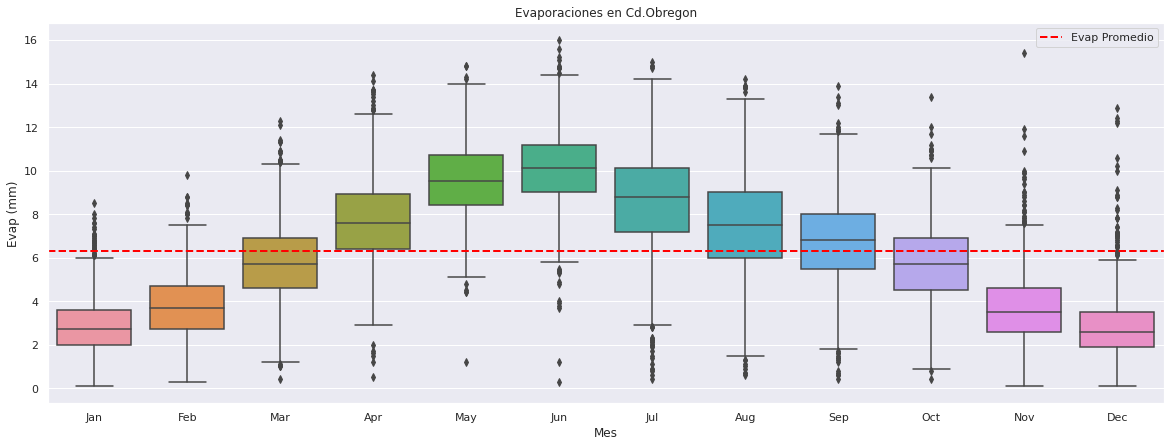

In [27]:

fig, axes = plt.subplots(1, 1, figsize=(20, 7), sharex=True)

sns.set(rc={'figure.figsize':(12, 6)})

start, end = '1990', '2012'




# Primer subplot
f1 = sns.boxplot(data=df_90, x='Mes', y='Evap')
l1 = plt.axhline(df_90.loc[start:end, 'Evap'].mean(), color='red', linestyle='--', linewidth=2, label='Evap Promedio');

plt.legend(loc='best')
plt.ylabel('Evap (mm)')
plt.xlabel('Mes');
plt.title('Evaporaciones en Cd.Obregon');


In [28]:
data_cols = ['Evap', 'Tmax', 'Tmin']
df_90_7d = df_90[data_cols].rolling(7, center=True,min_periods=1).mean()
df_90_30d = df_90[data_cols].rolling(30, center=True,min_periods=1).mean()
df_90_365d = df_90[data_cols].rolling(365, center=True,min_periods=1).mean() 

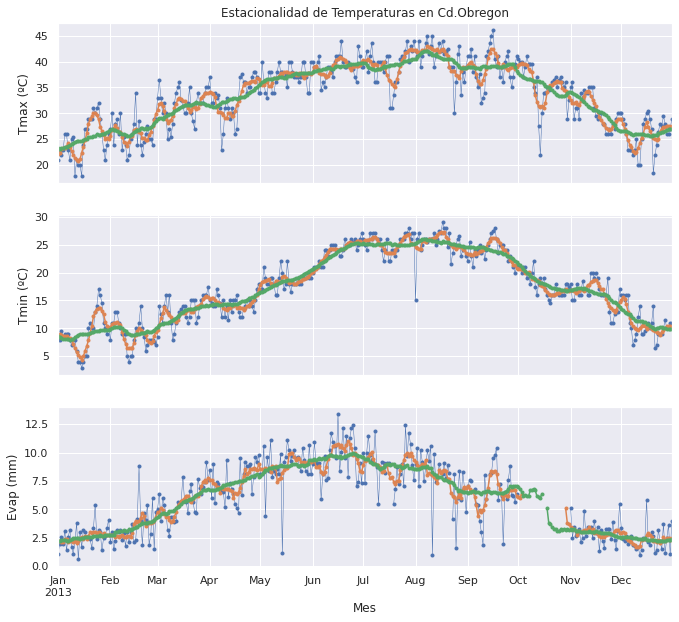

In [29]:

fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Rango de Tiempo

# Primer subplot
df_90.loc['2013', 'Tmax'].plot( marker='.', linestyle='-', linewidth=0.5, label='Diarios',ax=axes[0])
df_90_7d.loc['2013', 'Tmax'].plot(marker='.', linestyle='-', label='Promedio móvil 7 días',ax=axes[0])
df_90_30d.loc['2013', 'Tmax'].plot(marker='.', linestyle='-', label='Promedio móvil 30 días',ax=axes[0])

axes[0].set_ylabel('Tmax (ºC)');
axes[0].set_xlabel('');
axes[0].set_title('Estacionalidad de Temperaturas en Cd.Obregon');

# Subplot 2
df_90.loc['2013', 'Tmin'].plot( marker='.', linestyle='-', linewidth=0.5, label='Diarios',ax=axes[1])
df_90_7d.loc['2013', 'Tmin'].plot(marker='.', linestyle='-', label='Promedio móvil 7 días',ax=axes[1])
df_90_30d.loc['2013', 'Tmin'].plot(marker='.', linestyle='-', label='Promedio móvil 30 días',ax=axes[1])

axes[1].set_ylabel('Tmin (ºC)');
axes[1].set_xlabel('Mes');
axes[1].set_title('');

#Subplot 3

df_90.loc['2013', 'Evap'].plot( marker='.', linestyle='-', linewidth=0.5, label='Diarios',ax=axes[2])
df_90_7d.loc['2013', 'Evap'].plot(marker='.', linestyle='-', label='Promedio móvil 7 días',ax=axes[2])
df_90_30d.loc['2013', 'Evap'].plot(marker='.', linestyle='-', label='Promedio móvil 30 días',ax=axes[2])

axes[2].set_ylabel('Evap (mm)');
axes[2].set_xlabel('Mes');
axes[2].set_title('');

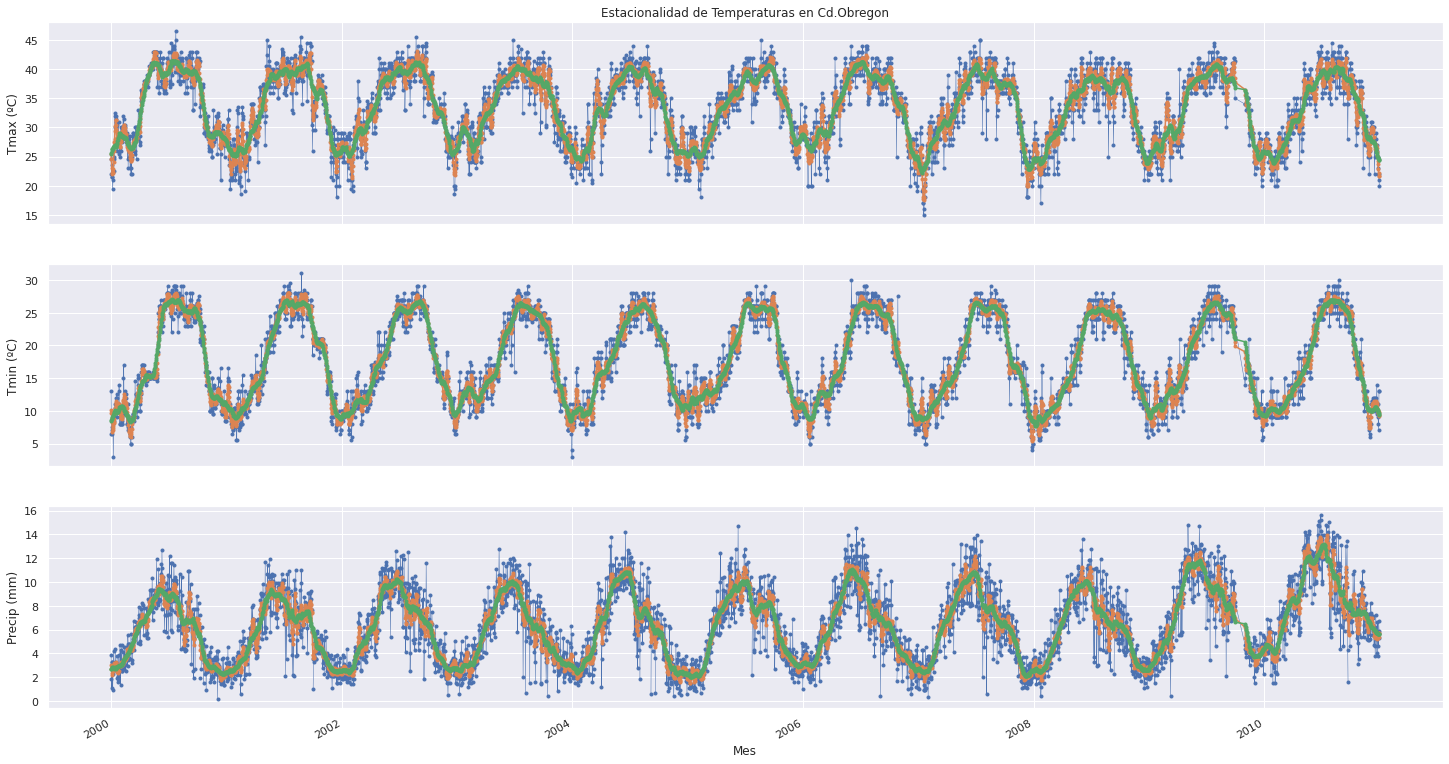

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(25, 14), sharex=True)
# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Rango de Tiempo
start,end = '2000','2010'
# Primer subplot
df_90.loc[start:end, 'Tmax'].plot( marker='.', linestyle='-', linewidth=0.5, label='Diarios',ax=axes[0])
df_90_7d.loc[start:end, 'Tmax'].plot(marker='.', linestyle='-', label='Promedio móvil 7 días',ax=axes[0])
df_90_30d.loc[start:end, 'Tmax'].plot(marker='.', linestyle='-', label='Promedio móvil 30 días',ax=axes[0])

axes[0].set_ylabel('Tmax (ºC)');
axes[0].set_xlabel('');
axes[0].set_title('Estacionalidad de Temperaturas en Cd.Obregon');

# Subplot 2
df_90.loc[start:end, 'Tmin'].plot( marker='.', linestyle='-', linewidth=0.5, label='Diarios',ax=axes[1])
df_90_7d.loc[start:end, 'Tmin'].plot(marker='.', linestyle='-', label='Promedio móvil 7 días',ax=axes[1])
df_90_30d.loc[start:end, 'Tmin'].plot(marker='.', linestyle='-', label='Promedio móvil 30 días',ax=axes[1])

axes[1].set_ylabel('Tmin (ºC)');
axes[1].set_xlabel('Mes');
axes[1].set_title('');

#Subplot 3

df_90.loc[start:end, 'Evap'].plot( marker='.', linestyle='-', linewidth=0.5, label='Diarios',ax=axes[2])
df_90_7d.loc[start:end, 'Evap'].plot(marker='.', linestyle='-', label='Promedio móvil 7 días',ax=axes[2])
df_90_30d.loc[start:end, 'Evap'].plot(marker='.', linestyle='-', label='Promedio móvil 30 días',ax=axes[2])

axes[2].set_ylabel('Precip (mm)');
axes[2].set_xlabel('Mes');
axes[2].set_title('');

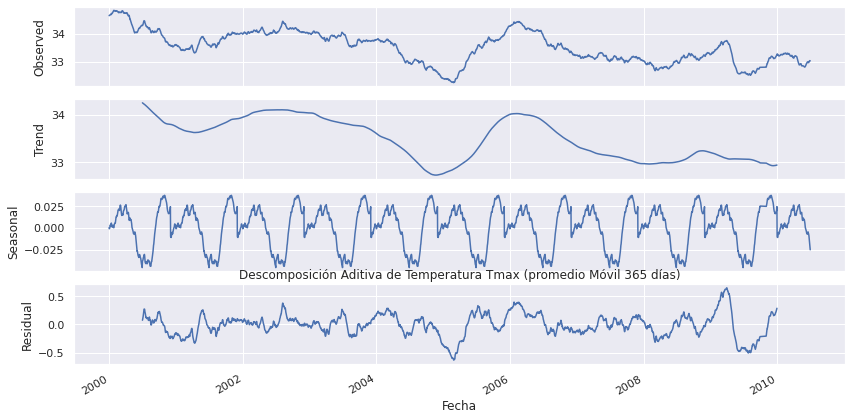

In [31]:
# Caso: Uso de datos con promedio móvil de 365 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2000-01', '2010-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365




resTmax = sm.tsa.seasonal_decompose(df_90_365d.loc[start:end, 'Tmax'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Temperatura Tmax (promedio Móvil 365 días)');

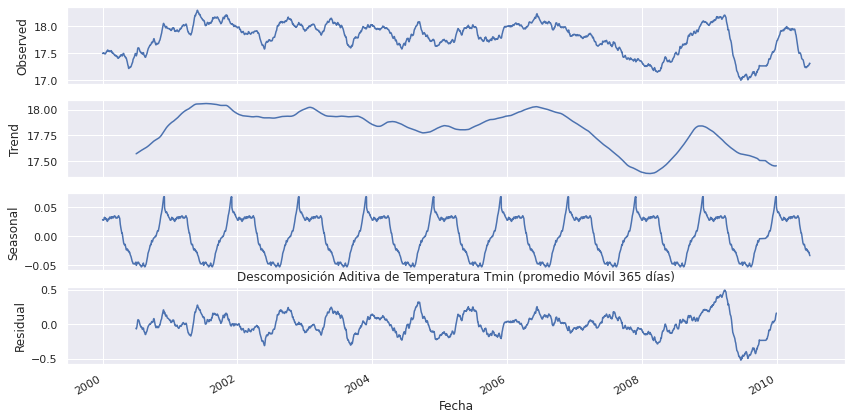

In [32]:
sns.set(rc={'figure.figsize':(12, 6)})

start, end = '2000-01', '2010-06'

decompfreq = 365




resTmax = sm.tsa.seasonal_decompose(df_90_365d.loc[start:end, 'Tmin'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Temperatura Tmin (promedio Móvil 365 días)');

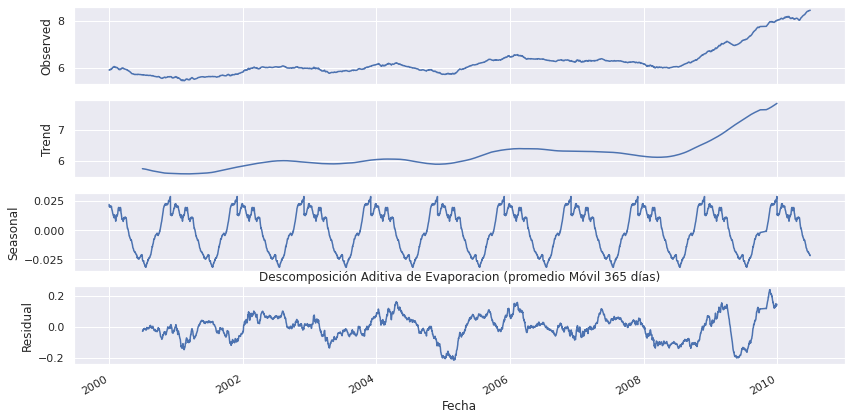

In [33]:
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '2000-01', '2010-06'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365




resTmax = sm.tsa.seasonal_decompose(df_90_365d.loc[start:end, 'Evap'].interpolate(),
                                    freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Evaporacion (promedio Móvil 365 días)');

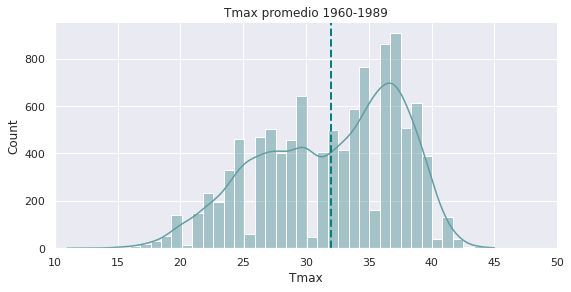

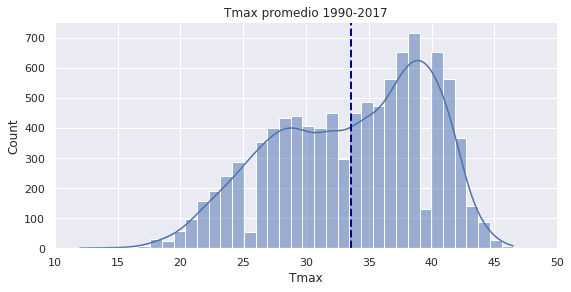

Tmax_promedio df_60 =  31.951136794240206 ºC
Tmax_promedio df_90 =  33.60730290456432 ºC


In [36]:

g1 = sns.displot(df_60.Tmax, kde=True, color='cadetblue', height=4, aspect=2);
plt.axvline(df_60.Tmax.mean(), linestyle='--', linewidth=2, color='teal');

g2 = sns.displot(df_90.Tmax, kde=True, height=4, aspect=2);
plt.axvline(df_90.Tmax.mean(), linestyle='--', linewidth=2, color='navy');

g1.set(title='Tmax promedio 1960-1989');
g2.set(title='Tmax promedio 1990-2017');
g1.set(xlim=(10,50))
g2.set(xlim=(10,50))



plt.show();

print('Tmax_promedio df_60 = ', df_60.Tmax.mean(), 'ºC' )
print('Tmax_promedio df_90 = ', df_90.Tmax.mean(), 'ºC' )

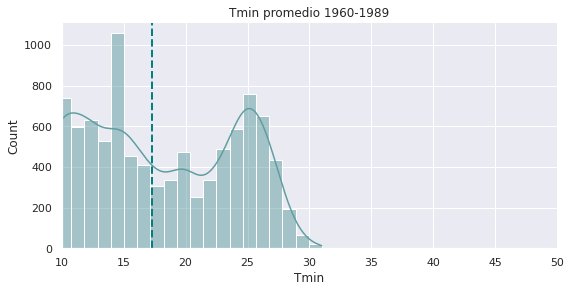

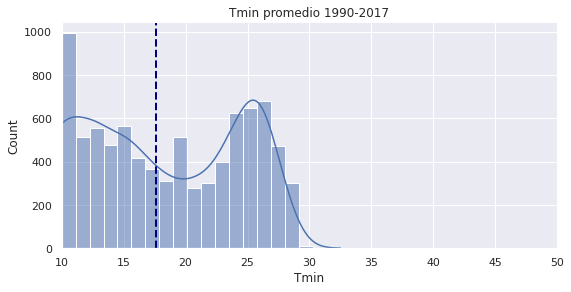

Tmin_promedio df_60 =  17.31259946949602 ºC
Tmin_promedio df_90 =  17.577800829875518 ºC


In [40]:

g1 = sns.displot(df_60.Tmin, kde=True, color='cadetblue', height=4, aspect=2);
plt.axvline(df_60.Tmin.mean(), linestyle='--', linewidth=2, color='teal');

g2 = sns.displot(df_90.Tmin, kde=True, height=4, aspect=2);
plt.axvline(df_90.Tmin.mean(), linestyle='--', linewidth=2, color='navy');

g1.set(title='Tmin promedio 1960-1989');
g2.set(title='Tmin promedio 1990-2017');
g1.set(xlim=(10,50))
g2.set(xlim=(10,50))



plt.show();

print('Tmin_promedio df_60 = ', df_60.Tmin.mean(), 'ºC' )
print('Tmin_promedio df_90 = ', df_90.Tmin.mean(), 'ºC' )